In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install spacy

In [ ]:
!pip install en_core_web_sm

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import transformers

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw_Reviews.csv')

In [ ]:
data

,Product_ID,Age,Title,Text_Review,Rating,Type
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,Intimate
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,Bottoms
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,Tops
...,...,...,...,...,...,...
23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,Dresses
23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,Tops
23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,Dresses
23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,Dresses


Data Cleaning and Preprocessing

In [ ]:
data.dtypes

Product_ID      int64
Age             int64
Title          object
Text_Review    object
Rating          int64
Type           object
dtype: object

In [ ]:
pd.options.display.float_format = '{:,.4f}'.format
missingness_skew_df = pd.DataFrame([{'column': c,
                      'dtype': data[c].dtype,
                       'distinct': data[c].nunique(),
                       '#_missing_val':data[c].isnull().sum(),
                       '%missingness': data[c].isnull().sum()*100/len(data),
                       } for c in data.columns])
add_emp_mchn_df_missingness_skew_df = missingness_skew_df.sort_values('%missingness', ascending=False)
add_emp_mchn_df_missingness_skew_df.head(100)

,column,dtype,distinct,#_missing_val,%missingness
2,Title,object,13993,3810,16.2224
3,Text_Review,object,22634,845,3.5979
5,Type,object,6,14,0.0596
0,Product_ID,int64,1206,0,0.0000
1,Age,int64,77,0,0.0000
4,Rating,int64,5,0,0.0000


Insights:

*   Title has some amount of missingness, we can extract the key words from the Text review instead of dropping this variable.
*   We'll check if NER (Named Entity Recognition) and Text Summarization using BART (Bidirectional and Auto-Regressive Transformers)



In [ ]:
#Handling missing values in "Text Reviews"

def fill_titles_with_ner(df, text_column='Text_Review', title_column='Title'):
    # Replace NaN values with empty strings in the text column
    df[text_column] = df[text_column].fillna('')

    # Only apply NER to rows where the title is missing
    missing_titles = df[title_column].isna()

    # Apply the NER extraction function to these rows
    df.loc[missing_titles, title_column] = df.loc[missing_titles, text_column].apply(extract_entities_as_title)
    return df

In [ ]:
missing_titles

NameError: name 'missing_titles' is not defined

In [ ]:
#NER Approach
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

#Creating a copy of original dataset to perform the analysis
ner_df = data.copy()

In [ ]:
ner_df

,Product_ID,Age,Title,Text_Review,Rating,Type
0,767,33,Could not Identify Title,Absolutely wonderful - silky and sexy and comf...,4,Intimate
1,1080,34,Could not Identify Title,Love this dress! it's sooo pretty. i happene...,5,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,Bottoms
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,Tops
...,...,...,...,...,...,...
23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,Dresses
23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,Tops
23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,Dresses
23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,Dresses


In [ ]:
def extract_entities_as_title(text):
  # Replace NaN values with empty strings in the text column
    doc = nlp(text)
    # Extract entities
    entities = [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'PRODUCT', 'FAC']]
    # Return the first entity found or an 'Could not Identify Title' string if no entity is found
    return entities[0] if entities else "Could not Identify Title"

def fill_titles_with_ner(df, text_column='Text_Review', title_column='Title'):
  # Replace NaN values with empty strings in the text column
    df[text_column] = df[text_column].fillna('')
    # Only apply NER to rows where the title is missing
    missing_titles = df[title_column].isna()
    print(f'Missing Titles: {missing_titles}')
    # Apply the NER extraction function to these rows
    df.loc[missing_titles, title_column] = df.loc[missing_titles, text_column].apply(extract_entities_as_title)
    return df

ner_df = fill_titles_with_ner(ner_df)


Missing Titles: 0        False
1        False
2        False
3        False
4        False
         ...  
23481    False
23482    False
23483    False
23484    False
23485    False
Name: Title, Length: 23486, dtype: bool


In [ ]:
placeholder_count = (ner_df['Title'] == "Could not Identify Title").sum()
print(f'Number of rows with "Could not Identify Title": {placeholder_count}')

Number of rows with "Could not Identify Title": 3707


Insight:
*   Even after performing NER to fill the Title columns, we still have 3707 rows where we couldn't extract the Title keywords from "Text_Reviews" column. Only 103 rows from initial 3810 missing values were filled. We'll try a hybrid approach of text summerization using BART(transformer) and fill the title column.





In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration
import torch

In [ ]:
model_name = 'facebook/bart-large-cnn'
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def summarize_text(text):
    inputs = tokenizer(text, max_length=1024, return_tensors="pt", truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to GPU

    # Generate summary with the model
    summary_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=35, early_stopping=True)
    # Decode the generated ids to get the summary text
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

def apply_summarization(df, text_column='Text_Review', title_column='Title'):
    for index, row in df.iterrows():
        if row[title_column] == "Could not Identify Title" or row[title_column] == "":
            try:

                summary_title = summarize_text(row[text_column])
                df.at[index, title_column] = summary_title
            except Exception as e:
                print(f"Error processing row {index}: {e}")
    return df

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [ ]:
bart_df = ner_df.copy()
bart_df = apply_summarization(bart_df)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1165: UserWarning: Unfeasible length constraints: `min_length` (56) is larger than the maximum possible length (35). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(


In [ ]:
bart_df.to_csv('bart_df.csv', index=False)

In [ ]:
placeholder_count = (bart_df['Title'] == "Could not Identify Title").sum()
print(f'Number of rows with "Could not Identify Title": {placeholder_count}')

Number of rows with "Could not Identify Title": 0


Insight: All the missing values in the Title column has been filled using the text summarizer. This took around 20 mins to complete.

 Understanding the Impact of Review Titles on Ratings


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
bart_df['Processed_Title'] = bart_df['Title'].str.lower().str.replace('[^\w\s]', ' ').str.replace('\s+', ' ').str.strip()

In [ ]:

vectorizer = CountVectorizer(stop_words='english', max_features=100)
X = vectorizer.fit_transform(bart_df['Processed_Title'])

# Get the feature names that correspond to the columns of X
words = vectorizer.get_feature_names_out()

# Sum the occurrences of each word
word_counts = np.sum(X.toarray(), axis=0)

# Create a DataFrame with the words and their counts
word_df = pd.DataFrame({'Word': words, 'Count': word_counts}).sort_values(by='Count', ascending=False)

In [ ]:
#Analyzing Correlation with Ratings
for word in words:
    bart_df[word] = bart_df['Processed_Title'].str.contains(f'\\b{word}\\b')

# Calculate the correlation of each binary word column with the 'Rating' column
correlations = {word: bart_df['Rating'].corr(bart_df[word]) for word in words}
correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation']).sort_values(by='Correlation', ascending=False)

<ipython-input-61-7162b47649ad>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bart_df[word] = bart_df['Processed_Title'].str.contains(f'\\b{word}\\b')
<ipython-input-61-7162b47649ad>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bart_df[word] = bart_df['Processed_Title'].str.contains(f'\\b{word}\\b')
<ipython-input-61-7162b47649ad>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

In [ ]:
# Display the words with the highest positive correlation
print(correlation_df.head())

# Display the words with the highest negative correlation
print(correlation_df.tail())

             Correlation
love              0.1236
perfect           0.1210
great             0.0970
comfortable       0.0765
best              0.0688
         Correlation
fabric       -0.0759
quality      -0.0772
big          -0.0809
boxy         -0.0853
wanted       -0.1256


Insights:

* Positive Descriptors: Words like "love," "perfect," "great," "comfortable," and "best" are positively correlated with higher ratings. This indicates that when reviewers use these terms in the title of their review, the product is likely to have a higher rating. These words are associated with satisfaction and approval.
* Quality Concerns: The word "quality" has a negative correlation with ratings, suggesting that when reviewers mention quality, it might be in a negative context, leading to lower ratings.
* Size Issues: The term "big" having a negative correlation could indicate issues with sizing - perhaps items are too large or not fitting as expected, which leads to dissatisfaction.
* Unmet Expectations: The word "wanted" being negatively correlated might reflect unmet expectations – customers may be saying they wanted something specific but did not receive it in the product.

**Detailed Sentiment Analysis: Aspect Based Sentiment Analysis**

This Technique is used to analyze text data to determine sentiment about specific aspects or features of a product. It invovles two steps
*   Aspect extraction
*   Sentiment Determination



In [ ]:
from collections import defaultdict
from textblob import TextBlob

#Aspect Extraction
def analyze_aspect_sentiments(text):
    doc = nlp(text)
    aspect_sentiments = {}
    for token in doc:
        # Looking for nouns or proper nouns that are subjects
        if token.dep_ in ('nsubj', 'nsubjpass') and token.pos_ in ('NOUN', 'PROPN'):
            # Extract the sentence in which the aspect is mentioned
            sentence = token.sent.text
            sentiment = analyze_sentiment(sentence)
            aspect_sentiments[token.lemma_] = sentiment
    return aspect_sentiments

    from textblob import TextBlob

#Sentiment Analysis
def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity



In [ ]:
def apply_absa_to_dataframe(df, text_column):

    # Initialize dictionaries to store aspects and sentiments
    aspects = {}
    sentiments = {}
    for index, row in df.iterrows():
        # Check for NaN or empty strings to avoid processing errors
        if pd.notna(row[text_column]) and row[text_column].strip():
            result = analyze_aspect_sentiments(row[text_column])
            aspects[index] = result
            sentiments[index] = {key: val for key, val in result.items()}

    # Convert dictionaries to DataFrame columns
    df['Aspects'] = pd.Series(aspects)
    df['Aspect Sentiments'] = pd.Series(sentiments)

    return df

In [ ]:
updated_df = apply_absa_to_dataframe(bart_df, 'Text_Review')

In [ ]:
updated_df.to_csv('updated_df.csv', index=False)

Note: I'm saving the files because the runtime gets disconnected frequently and i loose all the variables and had to rerun enitre notebook again.

In [ ]:
# Couldn't gain much insights from the Aspect Based Sentiment analysis,
# So proceeding Calculate the sentiment score from "text_review"

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

# Initialize the VADER sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

def get_sentiment_score(review):
    if pd.isna(review):
        return 0  # Assuming neutral sentiment for missing reviews
    return sia.polarity_scores(review)['compound']

updated_df['Sentiment_Score'] = updated_df['Text_Review'].apply(get_sentiment_score)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Analyzing consistency between the Sentiment Score and Rating.

In [ ]:
correlation = updated_df['Sentiment_Score'].corr(updated_df['Rating'])
print(f'Correlation between sentiment scores and ratings: {correlation}')

Correlation between sentiment scores and ratings: 0.40962671179253995


Insight: This suggests that as sentiment scores derived from the Text_Review become more positive, the ratings tend to be higher, and vice versa.

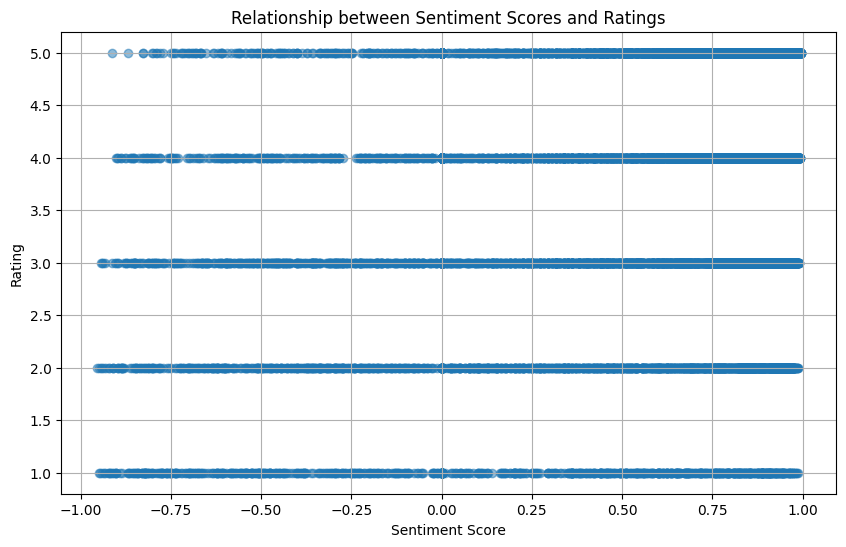

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(updated_df['Sentiment_Score'], updated_df['Rating'], alpha=0.5)
plt.title('Relationship between Sentiment Scores and Ratings')
plt.xlabel('Sentiment Score')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

Insights:
*   There's a visible concentration of reviews with higher sentiment scores corresponding to higher ratings, especially ratings of 4 and 5. This matches the expectation that more positive sentiments are associated with higher ratings.
*   Interestingly, there are a few reviews with negative sentiment scores (left side of the plot) that still have high ratings. This might indicate that the text of some reviews contains negatively perceived terms that VADER picks up, yet the overall rating given by the reviewer is high—this could be due to mixed sentiment in the text, or perhaps the reviewers are mentioning negative aspects but still find the overall product satisfactory.



**Understanding Data through Visualizations**

Understanding the Product types reviewd based on the Age groups.


In [ ]:
#Binning Age groups
binned_updated_df = updated_df.copy()
bins = [0, 18, 29, 39, 49, 59, 69, 79, 89, 99]
labels = ['0-18', '19-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
binned_updated_df['Age_Group'] = pd.cut(updated_df['Age'], bins=bins, labels=labels, right=False)

In [ ]:
grouped_df = binned_updated_df.groupby(['Age_Group', 'Type']).size().reset_index(name='Count')

In [ ]:
pivot_table = pd.pivot_table(grouped_df, values='Count', index=['Age_Group'], columns=['Type'], fill_value=0)

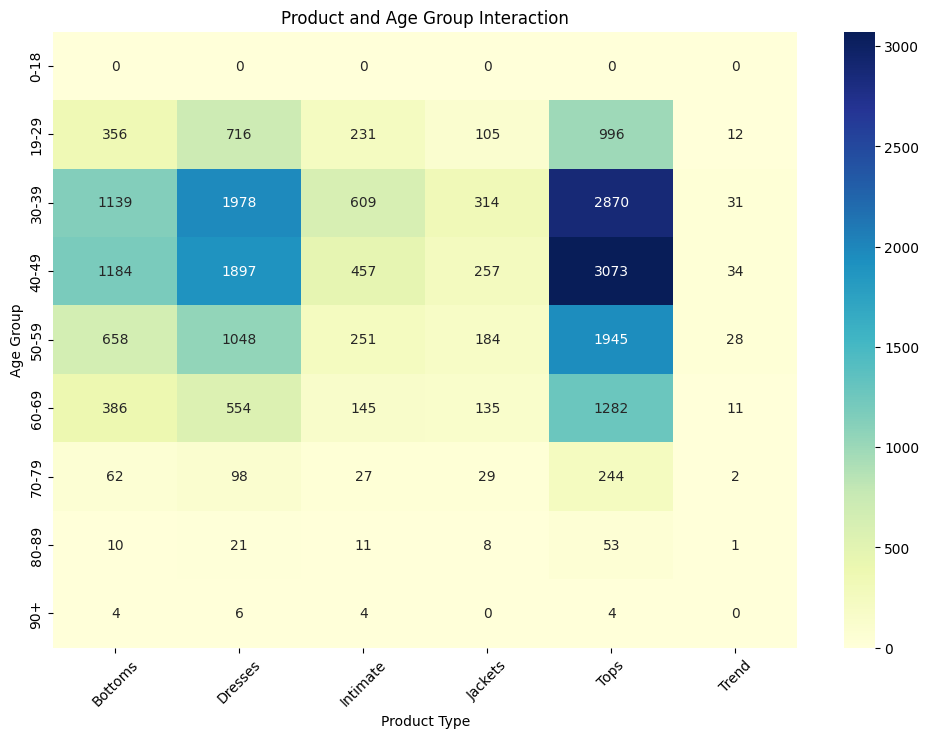

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Product and Age Group Interaction')
plt.ylabel('Age Group')
plt.xlabel('Product Type')
plt.xticks(rotation=45)
plt.show()

Insights:
*   Most Reviewed Product Types: The product types 'Tops' and 'Dresses' receive significantly more reviews across all age groups compared to other product types. This suggests that these categories are likely popular or widely purchased items among the customer base.
*   Age Group Engagement: The age groups 30-39 and 40-49 are the most active in reviewing products, especially in the 'Tops' and 'Dresses' categories.
The youngest (0-18) and oldest (90+) age groups have very few reviews, indicating lower engagement or fewer purchases among these demographics.
* Less Reviewed Product Types:  Categories such as 'Intimate', 'Jackets', and 'Trend' have significantly fewer reviews across all age groups, which could suggest these items are either less frequently purchased, less polarizing, or customers are less compelled to leave reviews for them.
* The most active reviewers are in the middle-aged brackets, which can inform marketing strategies, inventory decisions, and product design considerations to cater to this demographic's preferences and feedback.




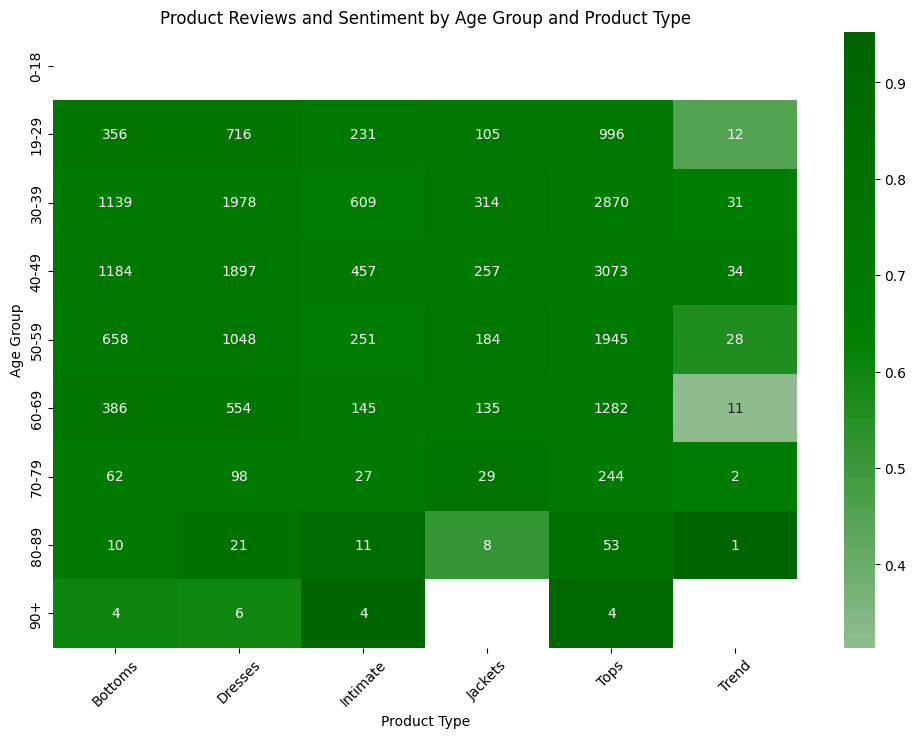

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

average_sentiments = binned_updated_df.groupby(['Age_Group', 'Type'])['Sentiment_Score'].mean().reset_index()
count_reviews = binned_updated_df.groupby(['Age_Group', 'Type']).size().reset_index(name='Count')


# Pivot table to prepare for heatmap
pivot_counts = count_reviews.pivot(index='Age_Group', columns='Type', values='Count')
pivot_sentiments = average_sentiments.pivot(index='Age_Group', columns='Type', values='Sentiment_Score')



#Define Colour Map
cmap = LinearSegmentedColormap.from_list(
    'RdYlGn', ['darkred', 'red', 'lightcoral', 'bisque', 'darkseagreen', 'green', 'darkgreen']
)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_sentiments, annot=pivot_counts, fmt='d', cmap=cmap, center=0)
plt.title('Product Reviews and Sentiment by Age Group and Product Type')
plt.ylabel('Age Group')
plt.xlabel('Product Type')
plt.xticks(rotation=45)
plt.show()

Insights:
*  General Sentiment: All cells are some shade of green, which indicates that the average sentiment across all age groups and product types is positive.
*   Sentiment Variation: While the overall sentiment is positive, there are some variations in the depth of color that indicate slight differences in sentiment across age groups and product types. Typically, darker shades would represent stronger positive sentiments, and lighter shades would represent weaker positive sentiments.



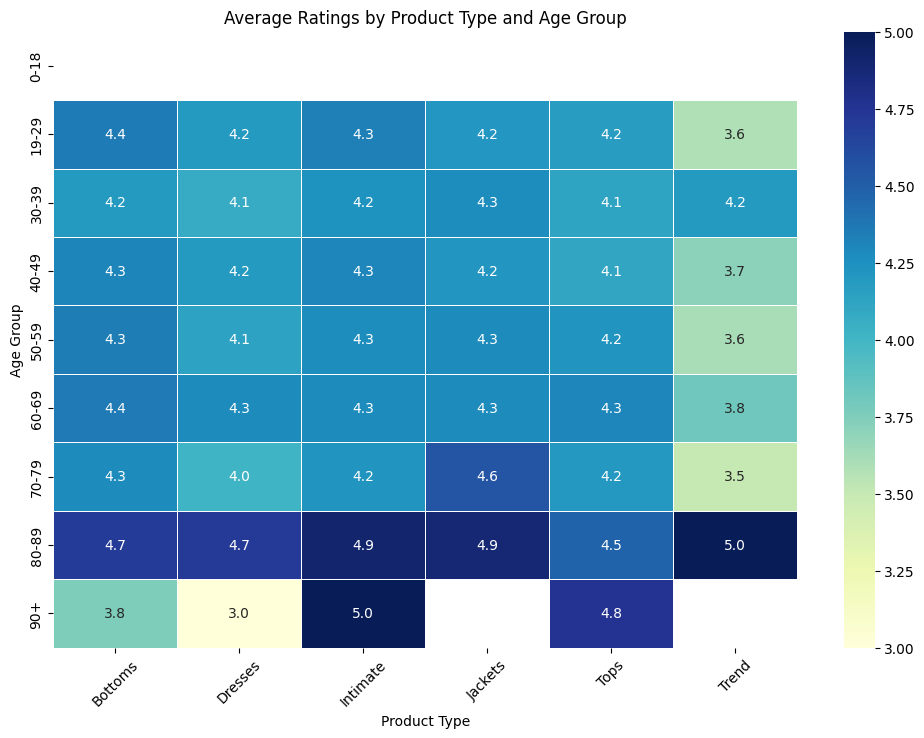

In [ ]:
average_ratings = binned_updated_df.groupby(['Age_Group', 'Type'])['Rating'].mean().reset_index()

pivot_avg_ratings = average_ratings.pivot(index='Age_Group', columns='Type', values='Rating')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_avg_ratings, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title('Average Ratings by Product Type and Age Group')
plt.ylabel('Age Group')
plt.xlabel('Product Type')
plt.xticks(rotation=45)
plt.show()

Insights:

* High Ratings Across the Board: Most product types across various age groups have high average ratings (above 4.0), which suggests general customer satisfaction with the products.
*Lower Ratings for 'Trend' Among Younger Customers: The 19-29 age group shows a significantly lower average rating for 'Trend', indicating potential dissatisfaction or mismatched expectations with the latest trends among younger customers.
*Consistent Satisfaction with 'Bottoms' and 'Dresses': These product types have consistently high ratings across most age groups, suggesting they are well-received and likely meet customers' expectations.
* Potential Areas for Improvement: The categories with lower ratings, such as 'Trend' in the 19-29 and 30-39 age groups, represent opportunities for improvement. Engaging with these customer segments to understand their specific grievances can provide actionable feedback for product enhancements.


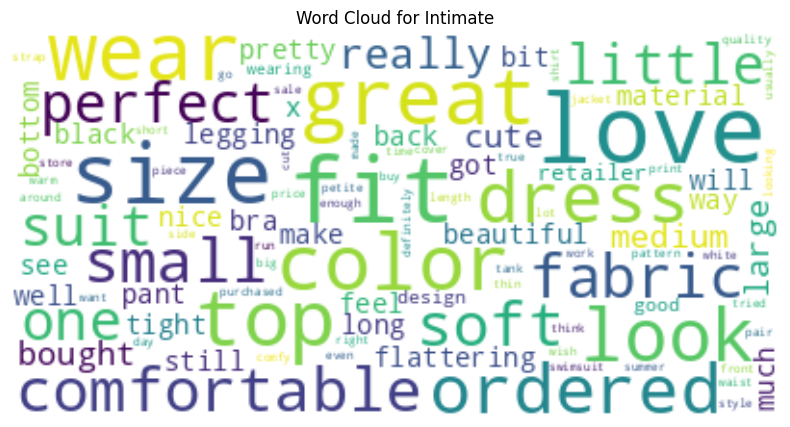

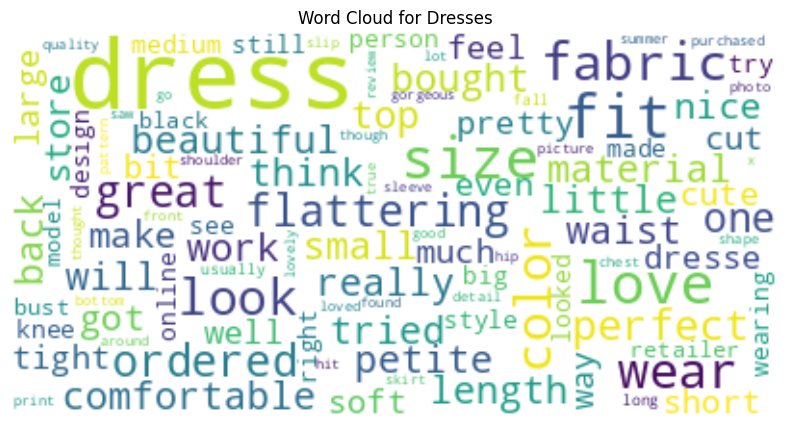

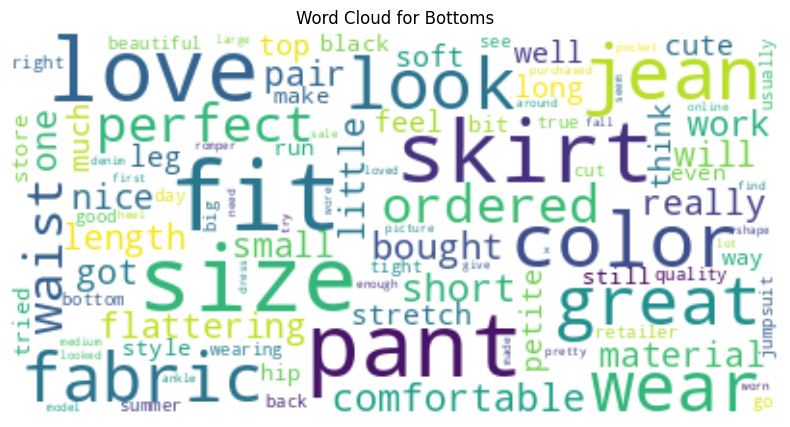

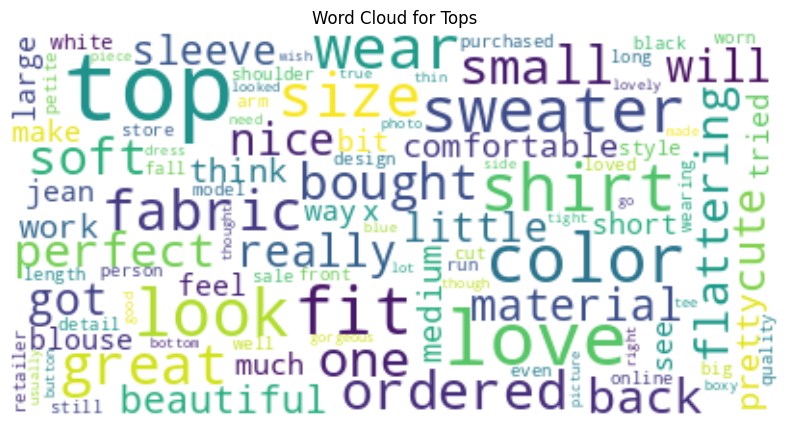

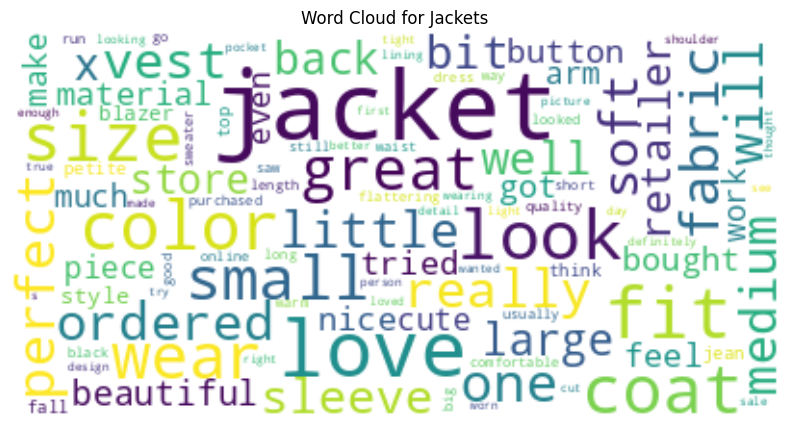

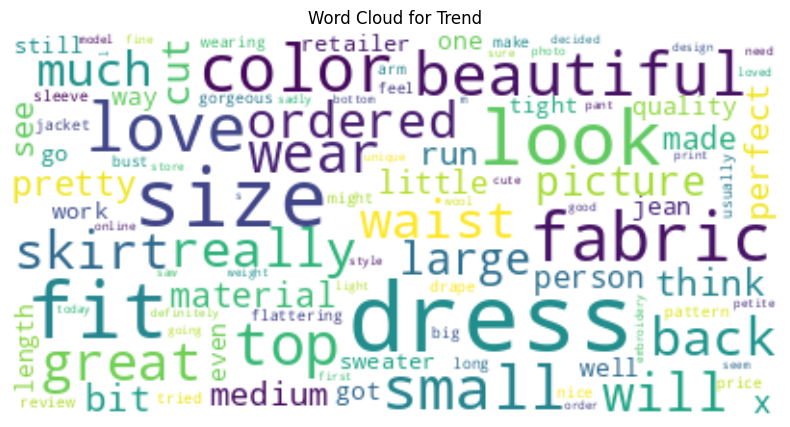

No reviews found for product type: nan


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud


binned_updated_df['Processed_Text'] = binned_updated_df['Text_Review'].str.lower().str.replace('[^\w\s]', '')

# Function to create a word cloud for each product type
def create_wordclouds(df, product_types):
    for product_type in product_types:
        # Filter the DataFrame for the current product type
        product_df = df[df['Type'] == product_type]

        if product_df.empty:
          print(f"No reviews found for product type: {product_type}")
          continue
        # Join all reviews into a single text
        text = ' '.join(review for review in product_df['Processed_Text'])

        # Generate word cloud
        wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate(text)

        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for {product_type}')
        plt.axis('off')
        plt.show()

# List of product types to create word clouds for
product_types = binned_updated_df['Type'].unique()

# Create and display word clouds
create_wordclouds(binned_updated_df, product_types)

Insights:

**Intimate**:
*   Key terms like "comfortable," "love," "soft," and "perfect" stand out, indicating positive customer sentiment regarding comfort and satisfaction.
*   The prominence of "color" and "size" suggests these are important factors for customers when purchasing intimate apparel.

**Dresses:**

*   Positive sentiments are expressed with words like "love," "perfect," "beautiful," and "flattering," suggesting overall satisfaction with dress purchases.
*   "Size," "fit," and "material" are significant, which indicates that these attributes are top of mind for customers when reviewing dresses.
*   The terms "ordered," "color," and "little" could relate to the online shopping experience and expectations around product accuracy and sizing.

**Bottoms:**

*   The frequent mention of "fit," "size," and "color" highlights the importance of these aspects in purchasing decisions for bottoms like jeans or skirts.
*   "Comfortable" and "great" suggest that comfort is a highly valued attribute.
*   Specific product types like "jean" and "skirt" indicate the kinds of bottoms being discussed, with "jean" being notably prominent.

**Tops:**

*  The presence of "fit" and "material" suggests customers are concerned with how tops fit and feel.
*  Words like "sweater" and "blouse" may point to specific types of tops that are commonly reviewed.


**Overall:**

* Across all product types, the emphasis on "size," "fit," "color," and "comfortable" implies that these are critical factors in customer satisfaction and decision-making.
* The overall sentiment in the reviews seems quite positive, with "love" and "great" being among the most common words. This indicates that customers are generally happy with their purchases.

**Main Pain Points Identified:**

* **Size and Fit:** These words appear in all categories, indicating that they are frequent topics of discussion. While they can indicate satisfaction, they can also point towards challenges customers face in selecting the right size or fit, which might be due to inconsistent sizing or unclear sizing guides.
* **Material and Fabric:** Mentioned in the context of dresses and tops, this might point to concerns about the quality or feel of the material, which may not meet customer expectations, particularly if they're shopping online and can't touch the fabric before buying.
* **Color:** This can refer to the appeal of color options but might also indicate issues such as the product color not matching the online images or colors that fade after washing.
* **Little:** This word could signify minor issues or details that, while not deal-breakers, are points of concern for customers, such as small design flaws or features that could be improved.
* Customer Service: Customer service teams should be aware that when customers mention "quality," "big," "boxy," or "wanted," these may be indicators of dissatisfaction that should be addressed proactively.

**Future Scope**
* **Follow-up Surveys:** Engage with customers who left negative feedback to gain deeper insights into their experiences.